In [15]:
import datetime as dt
from tecton.dal.mantle import Mantle
from tecton.dal.instrument.futures.market import Markets
import tecton.calculator.signal.technical as tech

import numpy as np
import pandas as pd

idx = pd.IndexSlice

In [16]:
m = Mantle()
markets = Markets.from_config()

In [17]:
load_local = False
ix = ['asset', 'date']
if load_local:
    px = pd.read_parquet('fut.parquet')
    px = px.sort_values(ix).set_index(ix)
else:
    table = m.select('futures_cont', start_date=dt.date(2010, 1, 1), end_date=dt.date(2024, 12, 31))
    px = table.to_pandas()
    px = px.sort_values(ix).set_index(ix)
    px.to_parquet('fut.parquet')

In [18]:
top_liquid = px.index.get_level_values('asset').unique().tolist()
px = px.groupby('asset').ffill()

### Signals

In [19]:
mac_windows = [(5, 20), (10, 50), (20, 100), (50, 200)]
macd_windows = [(12, 26, 9), (21, 63, 15), (42, 126, 21), (63, 252, 42)]
dc_windows = [20, 50, 100, 200]
adx_windows = [63]
signals = px.copy(deep=True)
### Compute Signals Per Market
for root in top_liquid:
    ##### MAC #####
    mac = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for short_window, long_window in mac_windows:
        col = f'signal_{short_window}_{long_window}'
        mac.loc[:, col] = tech.ma_crossover(mac['price'].values, fast_period=short_window, slow_period=long_window,)
        signal_cols.append(col)
    mac.loc[:, 'signal'] = mac[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'mac'] = mac['signal']

    ##### MACD #####
    macd = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for short_window, long_window, signal_period in macd_windows:
        col = f'signal_{short_window}_{long_window}_{signal_period}'
        macd.loc[:, col] = tech.macd(macd['price'].values, fast_period=short_window, slow_period=long_window, signal_period=signal_period)
        signal_cols.append(col)
    macd.loc[:, 'signal'] = macd[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'macd'] = macd['signal']

    ##### DC #####
    dc = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for window in dc_windows:
        col = f'signal_{window}'
        dc.loc[:, col] = tech.donchian_channels(
            high=dc['trading_session_high_price'].values,
            low=dc['trading_session_low_price'].values,
            close=dc['price'].values,
            period=window)
        signal_cols.append(col)

    dc.loc[:, 'signal'] = dc[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'dc'] = dc['signal']

    ##### ADX #####
    adx = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for window in adx_windows:
        col = f'signal_{window}'
        adx.loc[:, col] = tech.adx(
            high=adx['trading_session_high_price'].values,
            low=adx['trading_session_low_price'].values,
            close=adx['price'].values,
            period=window)
        signal_cols.append(col)

    adx.loc[:, 'signal'] = adx[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'adx'] = adx['signal']

signals.loc[:, 'forecast'] = signals[['mac', 'macd', 'dc']].mean(axis=1) * signals['adx']

In [20]:
signals['return'] = signals.groupby('asset')['price'].pct_change()

In [21]:
signals['forecast_shifted'] = signals.groupby('asset')['forecast'].shift(2)

In [22]:
mask = signals['return'].abs() > 1
signals_clipped = signals.loc[~mask, :]

In [23]:
signals_clipped.loc[:, 'vol'] = signals_clipped.rolling(252, center=False)['return'].std().mul(252**0.5)

In [24]:
signals_clipped.loc[:, 'weight'] = signals_clipped['forecast_shifted'] * (1/signals_clipped['vol']) / 40
rts = (signals_clipped.loc[:, 'weight'] * signals_clipped['return']).groupby('date').sum()

<Axes: xlabel='date'>

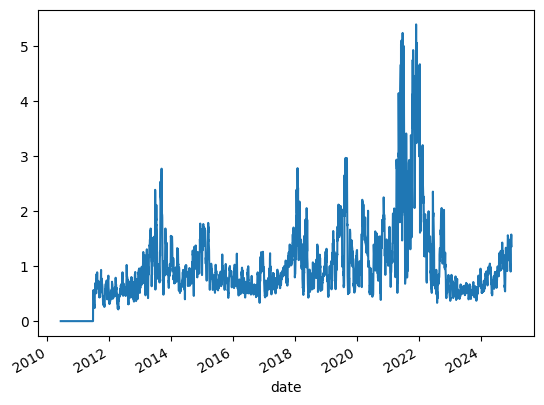

In [25]:
signals_clipped.assign(gross_wt=signals_clipped['weight'].abs()).groupby('date')['gross_wt'].sum().plot()

<Axes: xlabel='date'>

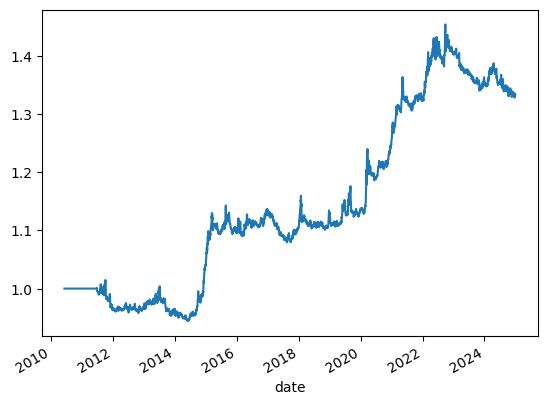

In [26]:
rts.add(1).cumprod().plot()

<Axes: xlabel='date'>

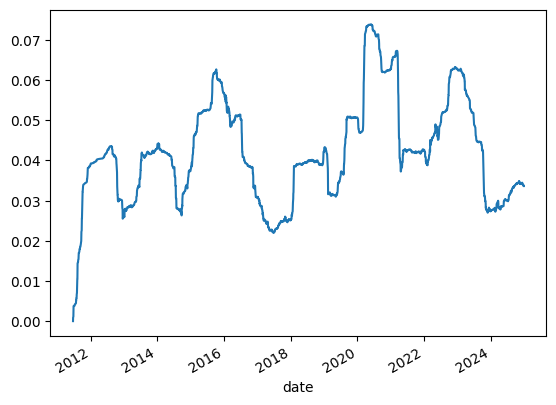

In [27]:
rts.rolling(252).std().mul(252**(1/2)).plot()

In [28]:
````

SyntaxError: invalid syntax (146514945.py, line 1)

In [ ]:
signals[mask]

,,symbol,price,open_interest,cleared_volume,opening_price,trading_session_low_price,trading_session_high_price,lowest_offer,highest_bid,mac,macd,dc,adx,forecast,return,forecast_shifted
asset,date,,,,,,,,,,,,,,,,


In [ ]:
````

In [ ]:
root = 'PA'
sd = dt.datetime(2020, 5, 10)
ed = dt.datetime(2020, 5, 16)

In [ ]:
signals.loc[idx[root, sd:ed], :]

MA, MACD, BBANDS

multiplier: ADX

### MA Crossover

In [ ]:
mac = px[['price']].copy()

windows = [(5, 20), (10, 50), (20, 100), (50, 200)]
# windows = [(20, 100)]
signal_cols = []
for short_window, long_window in windows:
    col = f'signal_{short_window}_{long_window}'
    mac.loc[:, col] = tech.ma_crossover(px['price'].values, fast_period=short_window, slow_period=long_window,)
    signal_cols.append(col)

mac.loc[:, 'signal'] = mac[signal_cols].sum(axis=1).div(len(signal_cols))
#
ax = mac['price'].plot(label='Price', figsize=(14, 7))
mac['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

### MACD

In [ ]:
macd = px[['price']].copy()

windows = [(12, 26, 9), (21, 63, 15), (42, 126, 21), (63, 252, 42)]
signal_cols = []
for short_window, long_window, signal_period in windows:
    col = f'signal_{short_window}_{long_window}_{signal_period}'
    macd.loc[:, col] = tech.macd(macd['price'].values, fast_period=short_window, slow_period=long_window, signal_period=signal_period)
    signal_cols.append(col)

macd.loc[:, 'signal'] = macd[signal_cols].sum(axis=1).div(len(signal_cols))

ax = macd['price'].plot(label='Price', figsize=(14, 7))
macd[['signal']].plot(ax=ax, secondary_y=True, label=['MACD', 'Signal'], color=['orange', 'purple'])
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('MACD')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

### Donchian Channels

In [ ]:
dc = px[['price', 'trading_session_low_price', 'trading_session_high_price']].copy()

windows = [20, 50, 100, 200]
signal_cols = []
for window in windows:
    col = f'signal_{window}'
    dc.loc[:, col] = tech.donchian_channels(
        high=dc['trading_session_high_price'].values,
        low=dc['trading_session_low_price'].values,
        close=dc['price'].values,
        period=window)
    signal_cols.append(col)

dc.loc[:, 'signal'] = dc[signal_cols].sum(axis=1).div(len(signal_cols))
ax = dc['price'].plot(label='Price', figsize=(14, 7))
dc['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

In [ ]:
adx = px[['price', 'trading_session_low_price', 'trading_session_high_price']].ffill().copy()

windows = [63]
signal_cols = []
for window in windows:
    col = f'signal_{window}'
    adx.loc[:, col] = tech.adx(
        high=adx['trading_session_high_price'].values,
        low=adx['trading_session_low_price'].values,
        close=adx['price'].values,
        period=window)
    signal_cols.append(col)

adx.loc[:, 'signal'] = adx[signal_cols].sum(axis=1).div(len(signal_cols))
ax = adx['price'].plot(label='Price', figsize=(14, 7))
adx['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

In [ ]:
signal = px[['price']].copy()
signal.loc[:, 'mac'] = mac['signal']
signal.loc[:, 'macd'] = macd['signal']
signal.loc[:, 'dc'] = dc['signal']
signal.loc[:, 'adx'] = adx['signal']
signal.loc[:, 'signal'] = signal[['mac', 'macd', 'dc']].mean(axis=1) * signal['adx']

ax = signal['price'].plot(label='Price', figsize=(14, 7))
signal['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')